In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

In [2]:
datos = read_csv('Giron_Lags.csv', encoding='latin-1', sep=";")


# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi',
       'Temp_Seca_Max_Dia_Prom', 'Temp_Seca_Max_Dia_Prom_1',
       'Temp_Seca_Max_Dia_Prom_2', 'Temp_Seca_Max_Dia_Prom_3',
       'Temp_Seca_Max_Dia_Prom_4', 'Temp_Seca_Max_Dia_Prom_5',
       'Temp_Seca_Max_Dia_Prom_6', 'Temp_Seca_Max_Sem', 'Temp_Seca_Max_Sem_1',
       'Temp_Seca_Max_Sem_2', 'Temp_Seca_Max_Sem_3', 'Temp_Seca_Max_Sem_4',
       'Temp_Seca_Max_Sem_5', 'Temp_Seca_Max_Sem_6', 'Temp_Seca_Min_Dia_Prom',
       'Temp_Seca_Min_Dia_Prom_1', 'Temp_Seca_Min_Dia_Prom_2',
       'Temp_Seca_Min_Dia_Prom_3', 'Temp_Seca_Min_Dia_Prom_4',
       'Temp_Seca_Min_Dia_Prom_5', 'Temp_Seca_Min_Dia_Prom_6',
       'Temp_Seca_Min_Sem', 'Temp_Seca_Min_Sem_1', 'Temp_Seca_Min_Sem_2',
       'Temp_Seca_Min_Sem_3', 'Temp_Seca_Min_Sem_4', 'Temp_Seca_Min_Sem_5',
       'Temp_Seca_Min_Sem_6', 'Prom_Dia_Preci', 'Prom_Dia_Preci_1',
       'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_4',
       'Prom_Dia_Preci_5', 'Prom_Dia_Preci_6', 'Total_Preci_Sem',
       'Total_Preci_Sem_1', 'Total_Preci_Sem_2', 'Total_Preci_Sem_3',
       'Total_Preci_Sem_4', 'Total_Preci_Sem_5', 'Total_Preci_Sem_6',
       'Temp_Max_Dia_Prom', 'Temp_Max_Dia_Prom_1', 'Temp_Max_Dia_Prom_2',
       'Temp_Max_Dia_Prom_3', 'Temp_Max_Dia_Prom_4', 'Temp_Max_Dia_Prom_5',
       'Temp_Max_Dia_Prom_6', 'Temp_Max_Sem', 'Temp_Max_Sem_1',
       'Temp_Max_Sem_2', 'Temp_Max_Sem_3', 'Temp_Max_Sem_4', 'Temp_Max_Sem_5',
       'Temp_Max_Sem_6', 'Temp_Min_Dia_Prom', 'Temp_Min_Dia_Prom_1',
       'Temp_Min_Dia_Prom_2', 'Temp_Min_Dia_Prom_3', 'Temp_Min_Dia_Prom_4',
       'Temp_Min_Dia_Prom_5', 'Temp_Min_Dia_Prom_6', 'Temp_Min_Sem',
       'Temp_Min_Sem_1', 'Temp_Min_Sem_2', 'Temp_Min_Sem_3', 'Temp_Min_Sem_4',
       'Temp_Min_Sem_5', 'Temp_Min_Sem_6', 'Hum_Rel_Max','Hum_Rel_Max_3',
                    'Hum_Rel_Max_1','Hum_Rel_Max_2',
       'Hum_Rel_Max_6', 'Hum_Rel_Min', 'Hum_Rel_Min_1', 'Hum_Rel_Min_2',
       'Hum_Rel_Min_3', 'Hum_Rel_Min_4', 'Hum_Rel_Min_5', 'Hum_Rel_Min_6'],axis=1)
datos.columns

Index(['Casos_Dengue', 'Hum_Rel_Max_4', 'Hum_Rel_Max_5'], dtype='object')

In [3]:
datos.isnull().sum()

Casos_Dengue      0
Hum_Rel_Max_4    13
Hum_Rel_Max_5    13
dtype: int64

In [4]:
from sklearn.impute import KNNImputer
knnImputer = KNNImputer (missing_values=np.nan, n_neighbors=2, 
                         weights="uniform", metric="nan_euclidean")

knnImputer.fit(datos[['Hum_Rel_Max_4']])
datos['Hum_Rel_Max_4'] = knnImputer.transform(datos[['Hum_Rel_Max_4']]).ravel()
knnImputer.fit(datos[['Hum_Rel_Max_5']])
datos['Hum_Rel_Max_5'] = knnImputer.transform(datos[['Hum_Rel_Max_5']]).ravel()

datos.isnull().sum()

Casos_Dengue     0
Hum_Rel_Max_4    0
Hum_Rel_Max_5    0
dtype: int64

In [5]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

254 110


In [6]:
f_columns = ['Hum_Rel_Max_4', 'Hum_Rel_Max_5']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [7]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
time_steps = 7
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Casos_Dengue, time_steps)
X_test, y_test = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(247, 7, 3) (247,) (103, 7, 3) (103,)


In [10]:
Giron_MLP_model_1 = keras.Sequential()

# CAPA DE ENTRADA
Giron_MLP_model_1.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))

#CAPA DE SALIDA

Giron_MLP_model_1.add(keras.layers.Dense(1))


#COMPILACIÓN DEL MODELO
Giron_MLP_model_1.compile(optimizer="adam", loss = 'mse')


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Giron_MLP_model_4.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_MLP = Giron_MLP_model_1.fit(X_train,y_train, validation_data=(X_test,y_test), 
                                     verbose=2, epochs=100, callbacks=[monitor, checkpoint],shuffle=False)
Giron_MLP_model_1.load_weights(model_filepath)

Epoch 1/100
8/8 - 2s - loss: 0.2478 - val_loss: 0.1590 - 2s/epoch - 283ms/step
Epoch 2/100
8/8 - 0s - loss: 0.1985 - val_loss: 0.0333 - 150ms/epoch - 19ms/step
Epoch 3/100
8/8 - 0s - loss: 0.0423 - val_loss: 0.0249 - 157ms/epoch - 20ms/step
Epoch 4/100
8/8 - 0s - loss: 0.0476 - val_loss: 0.0127 - 130ms/epoch - 16ms/step
Epoch 5/100
8/8 - 0s - loss: 0.0204 - val_loss: 0.0193 - 67ms/epoch - 8ms/step
Epoch 6/100
8/8 - 0s - loss: 0.0166 - val_loss: 0.0130 - 68ms/epoch - 8ms/step
Epoch 7/100
8/8 - 0s - loss: 0.0150 - val_loss: 0.0144 - 64ms/epoch - 8ms/step
Epoch 8/100
8/8 - 0s - loss: 0.0140 - val_loss: 0.0110 - 143ms/epoch - 18ms/step
Epoch 9/100
8/8 - 0s - loss: 0.0146 - val_loss: 0.0143 - 64ms/epoch - 8ms/step
Epoch 10/100
8/8 - 0s - loss: 0.0135 - val_loss: 0.0120 - 66ms/epoch - 8ms/step
Epoch 11/100
8/8 - 0s - loss: 0.0132 - val_loss: 0.0128 - 72ms/epoch - 9ms/step
Epoch 12/100
8/8 - 0s - loss: 0.0128 - val_loss: 0.0115 - 81ms/epoch - 10ms/step
Epoch 13/100
8/8 - 0s - loss: 0.0129 - v

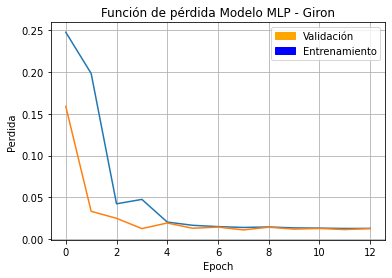

In [11]:
plt.figure(figsize=(6,4))
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo MLP - Giron')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.show()

In [12]:
y_pred = Giron_MLP_model_1.predict(X_test)
y_train_inv = dengue_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = dengue_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = dengue_transformer.inverse_transform(y_pred.reshape(1, -1))
print(y_train_inv.shape)
print(y_test_inv.shape)
print(y_pred_inv.shape)

4/4 [==============================] - 0s 3ms/step
(1, 247)
(1, 103)
(1, 103)


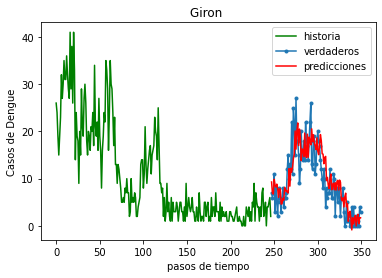

In [13]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="historia")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="verdaderos")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="predicciones")
plt.title('Giron ')
plt.ylabel('Casos de Dengue')
plt.xlabel('pasos de tiempo')
plt.legend()
plt.show();

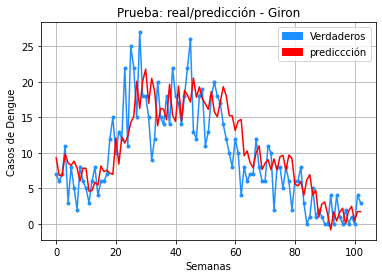

In [14]:
plt.title('Prueba: real/predicción - Giron' )
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.plot(y_test_inv.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv.flatten(), color= 'red', label="prediccción")
plt.grid(True)
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.show()

In [15]:
score = np.sqrt(metrics.mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("RMSE  Giron       : {}".format(score))
print("MSE Giron  = ", mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("MAE Giron = ", mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("r2_score Giron  = ", r2_score(y_test_inv.flatten(), y_pred_inv.flatten()))
print("explained_variance_score Giron  = ", explained_variance_score(y_test_inv.flatten(), y_pred_inv.flatten()))

RMSE  Giron       : 4.308293443503874
MSE Giron  =  18.561392395338473
MAE Giron =  3.3443066683209057
r2_score Giron  =  0.5845265171699177
explained_variance_score Giron  =  0.5992359013517159


In [16]:
# VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

resultados = pd.DataFrame({ 'Actuales':y_test_inv.flatten(), 'Predicciones': y_pred_inv.flatten()})
resultados['diferencia'] = resultados['Predicciones'] - resultados['Actuales']
resultados.head(60)

,Actuales,Predicciones,diferencia
0,7.0,9.292185,2.292185
1,6.0,6.859558,0.859558
2,7.0,6.751661,-0.248339
3,11.0,9.860558,-1.139442
4,3.0,8.574029,5.574029
5,8.0,8.236828,0.236828
6,5.0,8.842257,3.842257
7,2.0,7.864614,5.864614
8,8.0,6.028434,-1.971566
9,6.0,7.835218,1.835218


In [17]:
resultados.tail(60)

,Actuales,Predicciones,diferencia
43,18.0,18.796097,0.796097
44,22.0,18.152073,-3.847927
45,26.0,17.159416,-8.840584
46,13.0,20.541231,7.541231
47,12.0,17.832790,5.832790
48,18.0,19.296263,1.296263
49,19.0,17.608723,-1.391277
50,11.0,16.902477,5.902477
51,13.0,16.138660,3.138660
52,18.0,18.652159,0.652159
